In [113]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBRegressor

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

In [114]:
matplotlib.rcParams.update({'font.size': 12})
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [115]:
def apply_elbow_method(X):
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions.append(sum(np.min(cdist(X, 
                                            kmeanModel.cluster_centers_, 
                                            'euclidean'), 
                                      axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k');

In [116]:
def display_clusters_distribution(unique_labels, labels_counts):
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution');

In [117]:
def evaluate_preds(true_values_train, pred_values_train, true_values_test, pred_values_test):
    print('Train:\t' + 'R2 = ' + str(round(r2_score(true_values_train, pred_values_train), 6)) + 
          '\tMAE = ' + str(round(mean_absolute_error(true_values_train, pred_values_train), 6)) +
          '\n' +
          'Test:\t' + 'R2 = ' + str(round(r2_score(true_values_test, pred_values_test), 6)) +
          '\tMAE = ' + str(round(mean_absolute_error(true_values_test, pred_values_test), 6))
         )

In [118]:
def reduce_dims_to_3D_space_with_PCA(df):
    pca = PCA(n_components=3)
    components = pca.fit_transform(df)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])

In [119]:
def reduce_dims_to_3D_space_with_PCA_1(df):
    pca_1 = PCA(n_components=3)
    components_1 = pca_1.fit_transform(df)
    return pd.DataFrame(data = components_1, columns = ['component_1', 'component_2', 'component_3'])

In [120]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [121]:
DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [122]:
train_df = pd.read_csv(DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.000,47.982,29.443,6.000,7,9.000,1969,0.089,B,B,33,7976,5,nan,0,11,B,184966.931
15053,41,3.000,65.684,40.050,8.000,7,9.000,1978,0.000,B,B,46,10309,1,240.000,1,16,B,300009.450
4765,53,2.000,44.948,29.198,0.000,8,12.000,1968,0.050,B,B,34,7759,0,229.000,1,3,B,220925.909
5809,58,2.000,53.353,52.732,9.000,8,17.000,1977,0.438,B,B,23,5735,3,1084.000,0,5,B,175616.227
10783,99,1.000,39.649,23.776,7.000,11,12.000,1976,0.012,B,B,35,5776,1,2078.000,2,4,B,150226.532


Анализ целевой переменной

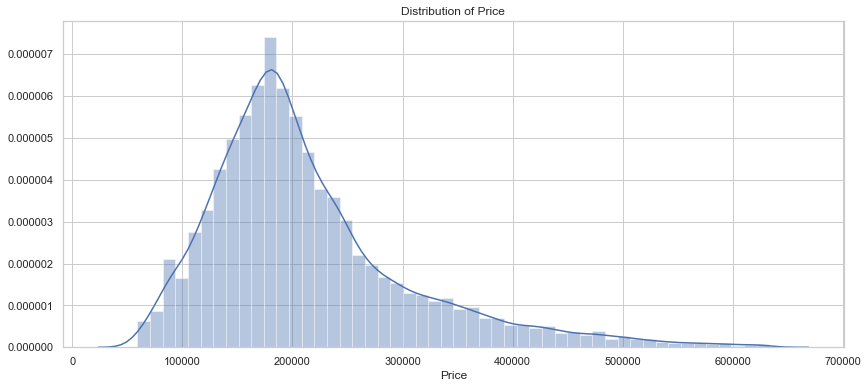

In [123]:
plt.figure(figsize = (14, 6))

sns.distplot(train_df['Price'])
plt.title('Distribution of Price');

In [124]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

target_mean, target_median, target_mode

(214138.86, 192269.64487934904, 59174.77802758122)

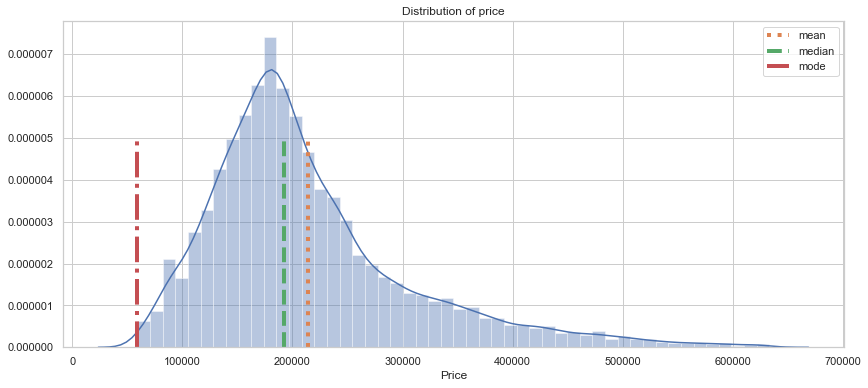

In [125]:
plt.figure(figsize = (14, 6))

sns.distplot(train_df['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of price')
plt.legend();

Чистим данные

In [126]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.median())
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = test_df.groupby(['Helthcare_2'])['Healthcare_1'].transform(lambda x: x.median())

In [127]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = test_df['Square'] - test_df['KitchenSquare']

In [128]:
train_df.drop(train_df[(train_df['KitchenSquare'] > 1000)].index, inplace=True)
test_df.drop(test_df[(test_df['KitchenSquare'] > 1000)].index, inplace=True)

train_df.drop(train_df[(train_df['LifeSquare'] > 1000)].index, inplace=True)
test_df.drop(test_df[(test_df['LifeSquare'] > 1000)].index, inplace=True)

train_df.drop(train_df[(train_df['HouseYear'] > 2020)].index, inplace=True)
test_df.drop(test_df[(test_df['HouseYear'] > 2020)].index, inplace=True)

In [129]:
train_df['total_square'] = train_df['Square'] + train_df['LifeSquare'] + train_df['KitchenSquare']
test_df['total_square'] = test_df['Square'] + test_df['LifeSquare'] + test_df['KitchenSquare']

In [130]:
train_df['priceM'] = train_df['Price'] / train_df['Square']
train_df.drop(train_df[(train_df['priceM'] > 10000) & (train_df['Square'] < 20)].index, inplace=True)

In [131]:
Shops_2 = pd.get_dummies(train_df['Shops_2'])
train_df['Shops_2'] = Shops_2

Shops_2 = pd.get_dummies(test_df['Shops_2'])
test_df['Shops_2'] = Shops_2

In [132]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']

train_df[feature_bin_names] = train_df[feature_bin_names].replace({'A':0, 'B':1})
test_df[feature_bin_names] = test_df[feature_bin_names].replace({'A':0, 'B':1})

In [133]:
train_df.drop(train_df[(train_df['Rooms'] > 15)].index, inplace=True)
train_df.drop(train_df[(train_df['Square'] > 200) & (train_df['priceM'] < 2000)].index, inplace=True)
train_df.drop(train_df[(train_df['KitchenSquare'] > 100)].index, inplace=True)

Создаем новые параметры

In [134]:
train_df['priceM'] = train_df['Price'] / train_df['Square']

In [135]:
price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'priceM':'median'})\
                        .rename(columns={'priceM':'priceMbyDistrict'})

train_df = train_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)

In [136]:
train_df['priceM'] = train_df['Price'] / train_df['Square']
train_df['priceByTS'] = train_df['Price'] / train_df['total_square']

In [137]:
price_by_social_2 = train_df.groupby(['Social_2'], as_index=False)\
                        .agg({'priceM':'median'})\
                        .rename(columns={'priceM':'priceMbySocial_2'})

train_df = train_df.merge(price_by_social_2, on=['Social_2'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_social_2, on=['Social_2'], how='left').set_index(test_df.index)

In [138]:
train_df['priceM'] = train_df['Price'] / train_df['Square']

In [139]:
price_by_house_year = train_df.groupby(['HouseYear'], as_index=False)\
                        .agg({'priceM':'median'})\
                        .rename(columns={'priceM':'priceMbyHouseYear'})

train_df = train_df.merge(price_by_house_year, on=['HouseYear'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_house_year, on=['HouseYear'], how='left').set_index(test_df.index)

In [140]:
train_df['priceByRoom'] = train_df['Price'] / train_df['Rooms']
train_df.loc[train_df['Rooms'] == 0, 'priceByRoom'] = train_df['priceByRoom'].median()

In [141]:
train_df['av_square_per_room'] = train_df['Square'] / train_df['Rooms']
test_df['av_square_per_room'] = test_df['Square'] / test_df['Rooms']

train_df.loc[train_df['av_square_per_room'].isna(), 'av_square_per_room'] = train_df['av_square_per_room'].median()
test_df.loc[test_df['av_square_per_room'].isna(), 'av_square_per_room'] = test_df['av_square_per_room'].median()

train_df.loc[train_df['av_square_per_room'] > 50, 'av_square_per_room'] = train_df['av_square_per_room'].median()
test_df.loc[test_df['av_square_per_room'] > 50, 'av_square_per_room'] = test_df['av_square_per_room'].median()


In [142]:
test_df.loc[test_df['priceMbyDistrict'].isna(), 'priceMbyDistrict'] = train_df['priceMbyDistrict'].median()
test_df.loc[test_df['priceMbySocial_2'].isna(), 'priceMbySocial_2'] = train_df['priceMbySocial_2'].median()
test_df.loc[test_df['priceMbyHouseYear'].isna(), 'priceMbyHouseYear'] = train_df['priceMbyHouseYear'].median()

Сохраняем копию для второго обучения

In [143]:
train_df1 = train_df.copy()
train_df1.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,total_square,priceM,priceMbyDistrict,priceByTS,priceMbySocial_2,priceMbyHouseYear,priceByRoom,av_square_per_room
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.000,47.982,29.443,6.000,7,9.000,1969,0.089,1,...,0,184966.931,83.424,3854.959,4358.275,2217.183,4463.364,4473.255,92483.465,23.991
15053,41,3.000,65.684,40.050,8.000,7,9.000,1978,0.000,1,...,0,300009.450,113.733,4567.491,4437.304,2637.836,4393.559,4317.685,100003.150,21.895
4765,53,2.000,44.948,29.198,0.000,8,12.000,1968,0.050,1,...,0,220925.909,74.146,4915.150,4845.919,2979.624,4824.286,4429.204,110462.954,22.474
5809,58,2.000,53.353,52.732,9.000,8,17.000,1977,0.438,1,...,0,175616.227,115.084,3291.592,2963.981,1525.976,2653.738,2899.451,87808.114,26.676
10783,99,1.000,39.649,23.776,7.000,11,12.000,1976,0.012,1,...,0,150226.532,70.425,3788.893,3992.031,2133.131,3986.565,4367.263,150226.532,39.649


Обучаем модель для предсказания цены за метр

In [144]:
#DROP price
train_df.drop(['Price'], axis='columns', inplace=True)

Добавляем priceM

In [145]:
target = ['priceM']
features = ['DistrictId',
            'Rooms',
            'Square',
            'priceMbyDistrict',
            'priceMbySocial_2',
            'priceMbyHouseYear',
            'av_square_per_room',
            'total_square',
            'LifeSquare',
            'KitchenSquare',
            'Floor',
            'HouseFloor',
            'HouseYear',
            'Social_1',
            'Social_2',
            'Helthcare_2',
            'Social_3',
            'Healthcare_1',
            'Shops_2', 
            'Shops_1']

In [146]:
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]

In [147]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                        columns=X_train.columns, 
                        index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                        columns=X_test.columns, 
                        index=X_test.index)

In [148]:
forest = RandomForestRegressor(max_depth=30, 
                               max_features=7, 
                               n_estimators=400,
                               random_state=42)

In [149]:
forest.fit(X_train_scaled, y_train)

y_train_preds = forest.predict(X_train_scaled)
y_test_preds = forest.predict(X_test_scaled)


In [150]:
y_pred = forest.predict(X_test_scaled)

preds = pd.DataFrame()
preds['Id'] = X_test_scaled.index
preds['priceM'] = y_pred

test_df = pd.merge(test_df, preds, on=['Id'])
test_df.set_index('Id', inplace=True)

priceByTS

In [151]:
target = ['priceByTS']
features = ['DistrictId',
            'Rooms',
            'Square',
            'priceM',
            'priceMbyDistrict',
            'priceMbySocial_2',
            'priceMbyHouseYear',
            'av_square_per_room',
            'total_square',
            'LifeSquare',
            'KitchenSquare',
            'Floor',
            'HouseFloor',
            'HouseYear',
            'Social_1',
            'Social_2',
            'Helthcare_2',
            'Social_3',
            'Healthcare_1',
            'Shops_2', 
            'Shops_1']

In [152]:
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]

In [153]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                        columns=X_train.columns, 
                        index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                        columns=X_test.columns, 
                        index=X_test.index)

In [154]:
forest.fit(X_train_scaled, y_train)

y_train_preds = forest.predict(X_train_scaled)
y_test_preds = forest.predict(X_test_scaled)


In [155]:
y_pred = forest.predict(X_test_scaled)

preds = pd.DataFrame()
preds['Id'] = X_test_scaled.index
preds['priceByTS'] = y_pred

test_df = pd.merge(test_df, preds, on=['Id'])
test_df.set_index('Id', inplace=True)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 25 columns):
DistrictId            5000 non-null int64
Rooms                 5000 non-null float64
Square                5000 non-null float64
LifeSquare            5000 non-null float64
KitchenSquare         5000 non-null float64
Floor                 5000 non-null int64
HouseFloor            5000 non-null float64
HouseYear             5000 non-null int64
Ecology_1             5000 non-null float64
Ecology_2             5000 non-null int64
Ecology_3             5000 non-null int64
Social_1              5000 non-null int64
Social_2              5000 non-null int64
Social_3              5000 non-null int64
Healthcare_1          5000 non-null float64
Helthcare_2           5000 non-null int64
Shops_1               5000 non-null int64
Shops_2               5000 non-null uint8
total_square          5000 non-null float64
priceMbyDistrict      5000 non-null float64
priceMbySocial_2      5000 non-n

Добавляем цену по комнатам

In [156]:
target = ['priceByRoom']
features = ['DistrictId',
            'Rooms',
            'Square',
            'priceM',
            'priceByTS',
            'priceMbyDistrict',
            'priceMbySocial_2',
            'priceMbyHouseYear',
            'av_square_per_room',
            'total_square',
            'LifeSquare',
            'KitchenSquare',
            'Floor',
            'HouseFloor',
            'HouseYear',
            'Social_1',
            'Social_2',
            'Helthcare_2',
            'Social_3',
            'Healthcare_1',
            'Shops_2', 
            'Shops_1']

In [157]:
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]

In [158]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                        columns=X_train.columns, 
                        index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                        columns=X_test.columns, 
                        index=X_test.index)

In [159]:
forest.fit(X_train_scaled, y_train)

y_train_preds = forest.predict(X_train_scaled)
y_test_preds = forest.predict(X_test_scaled)

In [160]:
y_pred_1 = forest.predict(X_test_scaled)

preds_1 = pd.DataFrame()
preds_1['Id'] = X_test_scaled.index
preds_1['priceByRoom'] = y_pred_1

In [161]:
test_df1 = pd.merge(test_df, preds_1, on=['Id'])
test_df1.set_index('Id', inplace=True)

In [162]:
test_df1.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,total_square,priceMbyDistrict,priceMbySocial_2,priceMbyHouseYear,av_square_per_room,priceM,priceByTS,priceByRoom
Id,,,,,,,,,,,,,,,,,,,,,
725,58,2.000,49.883,33.433,6.000,6,14.000,1972,0.310,1,...,0,0,89.315,2963.981,3494.789,4285.794,24.941,3124.205,1771.409,78610.023
15856,74,2.000,69.263,68.263,1.000,6,1.000,1977,0.076,1,...,2,0,138.526,3319.318,2690.038,2899.451,34.632,3409.627,1700.646,119610.468
5480,190,1.000,13.598,15.948,12.000,2,5.000,1909,0.000,1,...,5,0,41.546,8645.171,7870.592,4285.794,13.598,7619.208,4627.997,203754.717
15664,47,2.000,73.047,51.941,9.000,22,22.000,2007,0.102,1,...,3,0,133.987,4181.964,4325.526,4401.625,36.523,4120.551,2359.352,143898.255
14275,27,1.000,47.527,43.388,1.000,17,17.000,2017,0.072,1,...,0,1,91.915,2760.814,2746.899,3050.414,47.527,3166.745,1586.635,147762.536


Обучение всей модели

In [163]:
#train_df1_copy = train_df1.copy() # сохранить, чтобы не потерять цену при перезапуске

In [164]:
train_df1 = train_df1_copy.copy()
train_df1.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,total_square,priceM,priceMbyDistrict,priceByTS,priceMbySocial_2,priceMbyHouseYear,priceByRoom,av_square_per_room
Id,,,,,,,,,,,,,,,,,,,,,
14038,35,2.000,47.982,29.443,6.000,7,9.000,1969,0.089,1,...,0,184966.931,83.424,3854.959,4358.275,2217.183,4463.364,4473.255,92483.465,23.991
15053,41,3.000,65.684,40.050,8.000,7,9.000,1978,0.000,1,...,0,300009.450,113.733,4567.491,4437.304,2637.836,4393.559,4317.685,100003.150,21.895
4765,53,2.000,44.948,29.198,0.000,8,12.000,1968,0.050,1,...,0,220925.909,74.146,4915.150,4845.919,2979.624,4824.286,4429.204,110462.954,22.474
5809,58,2.000,53.353,52.732,9.000,8,17.000,1977,0.438,1,...,0,175616.227,115.084,3291.592,2963.981,1525.976,2653.738,2899.451,87808.114,26.676
10783,99,1.000,39.649,23.776,7.000,11,12.000,1976,0.012,1,...,0,150226.532,70.425,3788.893,3992.031,2133.131,3986.565,4367.263,150226.532,39.649


Обучение итоговой модели

In [165]:
target_1 = ['Price']
features_1 = ['DistrictId',   
              'total_square',
              'priceMbyDistrict',
              'priceMbySocial_2',
              'priceMbyHouseYear',
              'priceByRoom',
              'av_square_per_room',
              'priceM',
              'priceByTS',
              'Rooms',           
              'Square',
              'LifeSquare',
              'KitchenSquare',
              'Floor',
              'HouseFloor',
              'HouseYear',
              'Social_1',
              'Social_2',
              'Social_3',
              'Healthcare_1',
              'Helthcare_2',
              'Shops_1',
              'Shops_2']

Обучаем на полных данных

In [166]:
X_train_1 = train_df1[features_1]
y_train_1 = train_df1[target_1]

X_test_1 = test_df1[features_1]

Масштабирование признаков

In [167]:
scaler = StandardScaler()

X_train_scaled_1 = pd.DataFrame(scaler.fit_transform(X_train_1), 
                        columns=X_train_1.columns, 
                        index=X_train_1.index)
X_test_scaled_1 = pd.DataFrame(scaler.transform(X_test_1), 
                        columns=X_test_1.columns, 
                        index=X_test_1.index)

features_1 = X_train_scaled_1.iloc[:, :8]
features_1.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,9973.000,0.000,1.000,-1.156,-0.698,-0.331,0.564,3.637
total_square,9973.000,-0.000,1.000,-2.106,-0.748,-0.219,0.601,12.060
priceMbyDistrict,9973.000,0.000,1.000,-1.661,-0.994,0.207,0.636,4.791
priceMbySocial_2,9973.000,0.000,1.000,-2.694,-1.069,0.219,0.666,4.384
priceMbyHouseYear,9973.000,-0.000,1.000,-1.337,-1.160,0.660,0.822,5.303
priceByRoom,9973.000,0.000,1.000,-2.123,-0.689,-0.181,0.573,9.343
av_square_per_room,9973.000,0.000,1.000,-3.499,-0.761,-0.079,0.840,2.417
priceM,9973.000,-0.000,1.000,-2.520,-0.779,0.014,0.642,6.394


PCA

In [168]:
components_3d_pca_1 = reduce_dims_to_3D_space_with_PCA(features_1)
pca_1 = PCA(n_components=3)
components_3d_pca_train_1 = pca_1.fit_transform(features_1)

# for i, component in enumerate(pca_1.components_):
#     print("{} component: {}% of initial variance".format(i + 1, 
#           round(100 * pca_1.explained_variance_ratio_[i], 2)))
#     print(" + ".join("%.3f x %s" % (value, name)
#                      for value, name in zip(component,
#                                             features_1.columns)), '\n')

In [169]:
components_1 = pca_1.transform(X_test_scaled_1.iloc[:, :8])
components_3d_pca_test_1 = pd.DataFrame(data = components_1, 
                                     columns = ['component_1', 'component_2', 'component_3'])

In [170]:
X_train_pca_1 = pd.concat([X_train_1.reset_index(), 
                  components_3d_pca_1], axis=1)
X_test_pca_1 = pd.concat([X_test_1.reset_index(), 
                  components_3d_pca_test_1], axis=1)

K-means

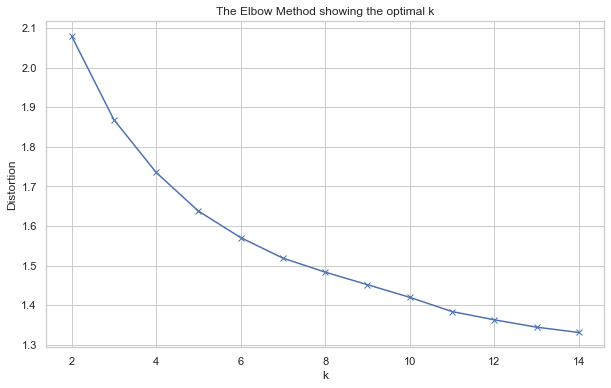

In [171]:
apply_elbow_method(features_1) 

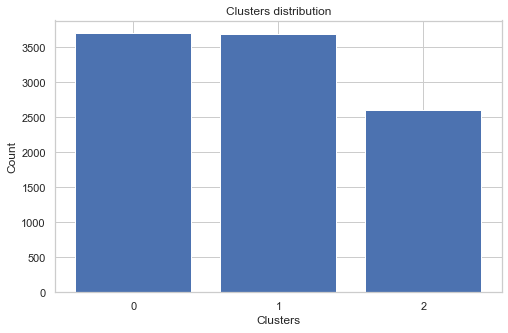

In [172]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_clast_3 = kmeans_3.fit_predict(features_1)
labels_clast_3 = pd.Series(labels_clast_3, name='clusters_3')

unique, counts = np.unique(labels_clast_3, return_counts=True)
display_clusters_distribution(unique, counts)

In [173]:
clusters_3_dummies = pd.get_dummies(labels_clast_3, drop_first=True, prefix='clusters_3')

X_train_ext = pd.concat([X_train_pca_1.reset_index(), 
                   clusters_3_dummies], axis=1)
X_train_ext.shape

(9973, 30)

In [174]:
labels_clast_3 = kmeans_3.predict(X_test_scaled_1.iloc[:, :8])

clusters_3_dummies = pd.get_dummies(labels_clast_3, drop_first=True, prefix='clusters_3')

X_test_ext = pd.concat([X_test_pca_1.reset_index(), 
                   clusters_3_dummies], axis=1)
X_test_ext.shape

(5000, 30)

In [175]:
# 30/7

forest_2 = RandomForestRegressor(max_depth=15, 
                                 max_features=19, 
                                 n_estimators=400,
                                 random_state=42,
                                 bootstrap=True,
                                 min_samples_leaf=2,
                                 min_samples_split=12)

In [176]:
forest_2.fit(X_train_ext, y_train_1)
# y_train_preds_1 = forest_2.predict(X_train_ext)
# y_test_preds_1 = forest_2.predict(X_test_ext)
# evaluate_preds(y_train_1, y_train_preds_1, y_test_1, y_test_preds_1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=19, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [177]:
# feature_importances = pd.DataFrame(zip(X_train_ext.columns, forest_2.feature_importances_), 
#                                   columns=['feature_name', 'importance'])
# feature_importances.sort_values(by='importance', ascending=False)

Сохранение результатов

In [178]:
y_pred_1 = forest_2.predict(X_test_ext)

preds_1 = pd.DataFrame()
preds_1['Id'] = X_test_1.index
preds_1['Price'] = y_pred_1
preds_1.to_csv('Korablina_submission.csv', index=False)